In [1]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pandas as pd
import torch
import umap


2023-09-11 01:17:43.431067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 01:17:43.557664: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 01:17:44.080173: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-11 01:17:44.080240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
import sys
sys.path.append('/home/huan/Documents/MedDiff')
from models.vae import VariationalAutoencoder

In [3]:
tasks = [
    'mortality_48h',
    'ARF_4h', 
    'ARF_12h',
    'Shock_4h',
    'Shock_12h',
]
task = tasks[1]

s = np.load('../FIDDLE_eicu/features/{}/s.npz'.format(task))
X = np.load('../FIDDLE_eicu/features/{}/X.npz'.format(task))
s_feature_names = json.load(open('../FIDDLE_eicu/features/{}/s.feature_names.json'.format(task), 'r'))
X_feature_names = json.load(open('../FIDDLE_eicu/features/{}/X.feature_names.json'.format(task), 'r'))
df_pop = pd.read_csv('../FIDDLE_eicu/population/{}.csv'.format(task))
x_s = torch.sparse_coo_tensor(torch.tensor(s['coords']), torch.tensor(s['data'])).to_dense().to(torch.float32)
x_t = torch.sparse_coo_tensor(torch.tensor(X['coords']), torch.tensor(X['data'])).to_dense().to(torch.float32)
x_t = x_t.sum(dim=1).to(torch.float32)

In [4]:

svae = VariationalAutoencoder(717).to('cuda')
tvae = VariationalAutoencoder(5854).to('cuda')
tvae = torch.load('../Synthetic_MIMIC/vae_tmp.pt')
svae = torch.load('../Synthetic_MIMIC/vae_stat.pt')

In [5]:
mu, logvar = tvae.encode(x_t.cuda())
zt = tvae.reparameterize(mu, logvar)


In [6]:
mu, logvar = svae.encode(x_s.cuda())
zs = tvae.reparameterize(mu, logvar)


In [8]:
x_s.shape

torch.Size([138840, 717])

In [10]:
y = df_pop.ARF_LABEL.values

In [11]:
manifold = umap.UMAP().fit(zt.detach().cpu().numpy(), y)

In [12]:
import umap.plot

<AxesSubplot:>

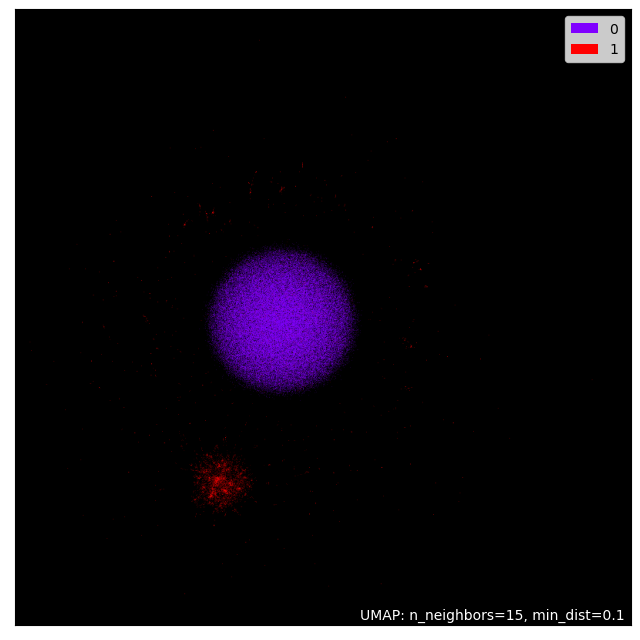

In [13]:
umap.plot.points(manifold, labels=y, theme="fire")

In [14]:
manifolds = umap.UMAP().fit(zs.detach().cpu().numpy(), y)

In [19]:
manifold.embedding_

array([[ 2.9160135,  1.0676925],
       [-1.2270916,  1.3224319],
       [-1.7773929,  2.3657584],
       ...,
       [ 0.7107043,  2.2384205],
       [ 2.1737633,  2.374802 ],
       [-0.6413896,  2.101768 ]], dtype=float32)

<AxesSubplot:>

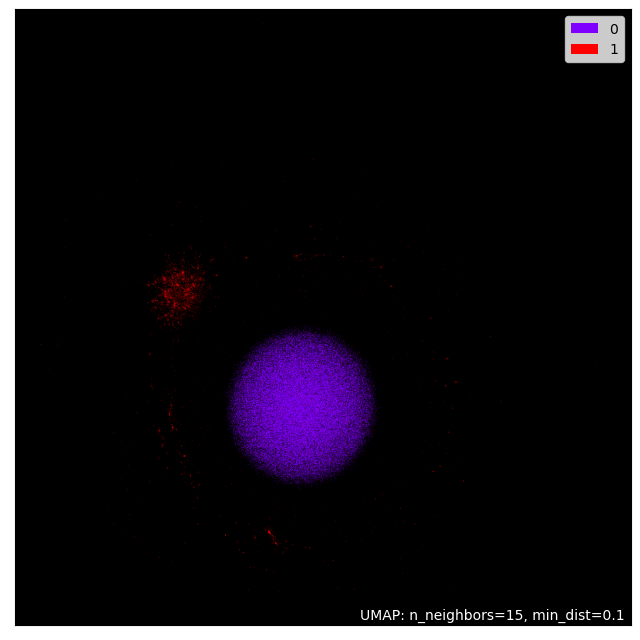

In [15]:
umap.plot.points(manifolds, labels=y, theme="fire")

In [16]:
import matplotlib.pyplot as pl
import numpy as np
import ot
from ot.gromov import gromov_wasserstein, fused_gromov_wasserstein

In [25]:
# We create two 1D random measures
n = 20  # number of points in the first distribution
n2 = 30  # number of points in the second distribution
sig = 1  # std of first distribution
sig2 = 0.1  # std of second distribution

np.random.seed(0)

phi = np.arange(n)[:, None]
xs = phi + sig * np.random.randn(n, 1)
ys = np.vstack((np.ones((n // 2, 1)), 0 * np.ones((n // 2, 1)))) + sig2 * np.random.randn(n, 1)

phi2 = np.arange(n2)[:, None]
xt = phi2 + sig * np.random.randn(n2, 1)
yt = np.vstack((np.ones((n2 // 2, 1)), 0 * np.ones((n2 // 2, 1)))) + sig2 * np.random.randn(n2, 1)
yt = yt[::-1, :]

p = ot.unif(n)
q = ot.unif(n2)

In [26]:
xt.shape

(30, 1)

In [35]:
xt = manifold.embedding_[0:100,0][:,None]
yt = manifold.embedding_[0:100:,1][:,None]
xs = manifolds.embedding_[0:100:,0][:,None]
ys = manifolds.embedding_[0:100:,0][:,None]

In [32]:
xt.shape

(138840, 1)

In [36]:
C1 = ot.dist(xs)
C2 = ot.dist(xt)
M = ot.dist(ys, yt)
w1 = ot.unif(C1.shape[0])
w2 = ot.unif(C2.shape[0])
Got = ot.emd([], [], M)

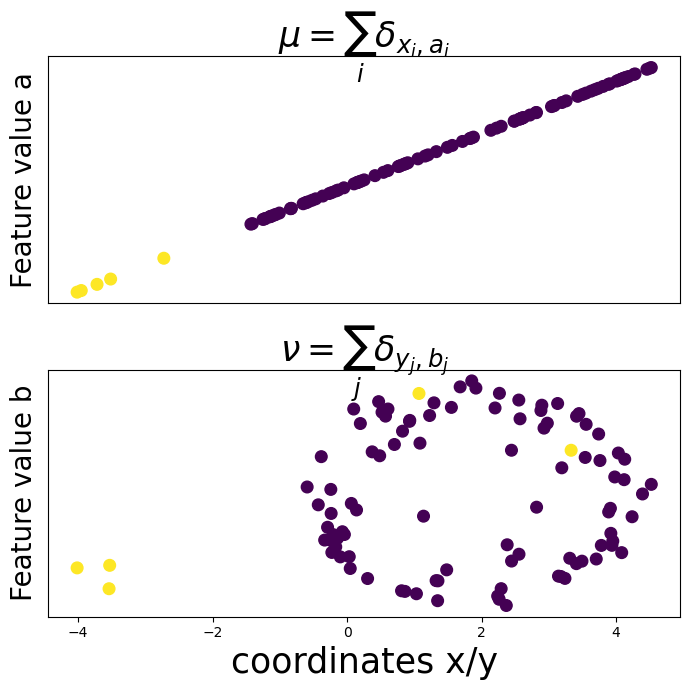

In [38]:
pl.figure(1, (7, 7))

pl.subplot(2, 1, 1)

pl.scatter(ys, xs, c=y[0:100], s=70)
pl.ylabel('Feature value a', fontsize=20)
pl.title('$\mu=\sum_i \delta_{x_i,a_i}$', fontsize=25, y=1)
pl.xticks(())
pl.yticks(())
pl.subplot(2, 1, 2)
pl.scatter(yt, xt, c=y[0:100], s=70)
pl.xlabel('coordinates x/y', fontsize=25)
pl.ylabel('Feature value b', fontsize=20)
pl.title('$\\nu=\sum_j \delta_{y_j,b_j}$', fontsize=25, y=1)
pl.yticks(())
pl.tight_layout()
pl.show()

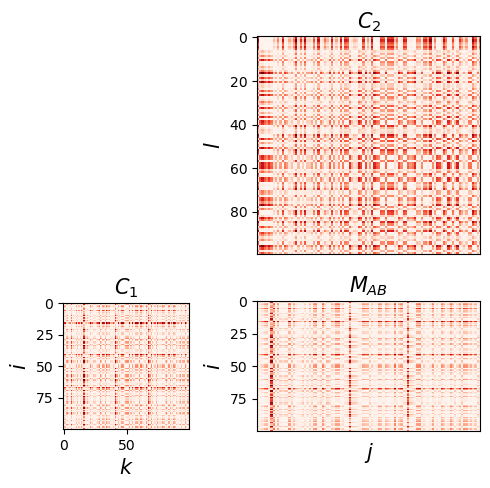

In [39]:
cmap = 'Reds'

pl.figure(2, (5, 5))
fs = 15
# l_x = [0, 5, 10, 15]
# l_y = [0, 5, 10, 15, 20, 25]
gs = pl.GridSpec(5, 5)

ax1 = pl.subplot(gs[3:, :2])

pl.imshow(C1, cmap=cmap, interpolation='nearest')
pl.title("$C_1$", fontsize=fs)
pl.xlabel("$k$", fontsize=fs)
pl.ylabel("$i$", fontsize=fs)
# pl.xticks(l_x)
# pl.yticks(l_x)

ax2 = pl.subplot(gs[:3, 2:])

pl.imshow(C2, cmap=cmap, interpolation='nearest')
pl.title("$C_2$", fontsize=fs)
pl.ylabel("$l$", fontsize=fs)
pl.xticks(())
# pl.yticks(l_y)
ax2.set_aspect('auto')

ax3 = pl.subplot(gs[3:, 2:], sharex=ax2, sharey=ax1)
pl.imshow(M, cmap=cmap, interpolation='nearest')
# pl.yticks(l_x)
# pl.xticks(l_y)
pl.ylabel("$i$", fontsize=fs)
pl.title("$M_{AB}$", fontsize=fs)
pl.xlabel("$j$", fontsize=fs)
pl.tight_layout()
ax3.set_aspect('auto')
pl.show()

In [41]:
alpha = 1e-3
p = ot.unif(100)
q = ot.unif(100)
ot.tic()
Gwg, logw = fused_gromov_wasserstein(M, C1, C2, p, q, loss_fun='square_loss', alpha=alpha, verbose=True, log=True)
ot.toc()

# reload_ext WGW
Gg, log = gromov_wasserstein(C1, C2, p, q, loss_fun='square_loss', verbose=True, log=True)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|6.633854e+00|0.000000e+00|0.000000e+00
    1|5.091790e-01|1.202853e+01|6.124676e+00
    2|5.091654e-01|2.657007e-05|1.352856e-05
    3|5.091654e-01|0.000000e+00|0.000000e+00
Elapsed time : 0.027248859405517578 s
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|8.863853e+01|0.000000e+00|0.000000e+00
    1|6.725236e+01|3.179988e-01|2.138617e+01
    2|1.717066e+01|2.916701e+00|5.008169e+01
    3|1.717066e+01|0.000000e+00|0.000000e+00


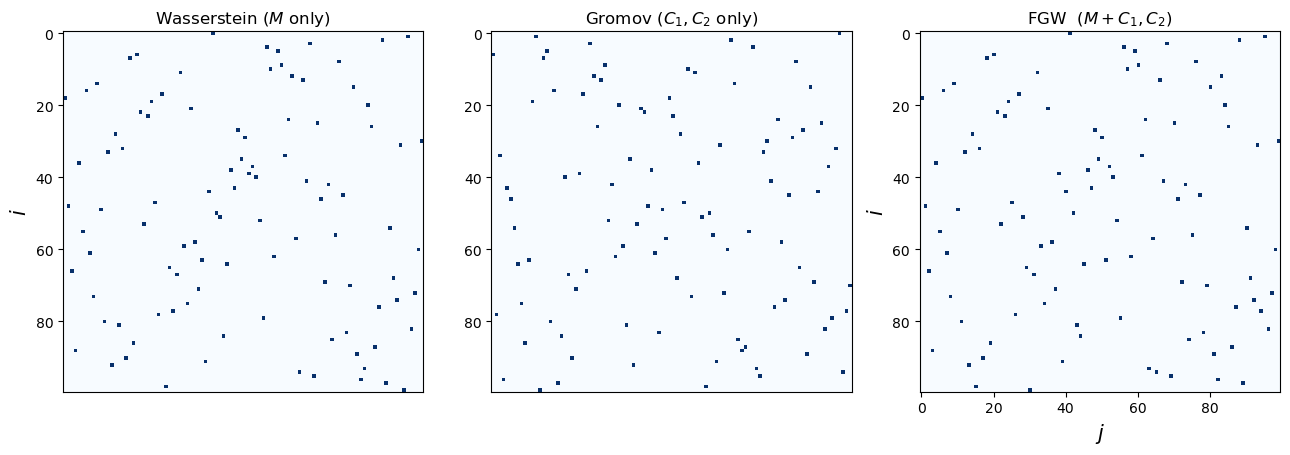

In [42]:
# visu OT matrix
cmap = 'Blues'
fs = 15
pl.figure(3, (13, 5))
pl.clf()
pl.subplot(1, 3, 1)
pl.imshow(Got, cmap=cmap, interpolation='nearest')
pl.ylabel("$i$", fontsize=fs)
pl.xticks(())

pl.title('Wasserstein ($M$ only)')

pl.subplot(1, 3, 2)
pl.imshow(Gg, cmap=cmap, interpolation='nearest')
pl.title('Gromov ($C_1,C_2$ only)')
pl.xticks(())
pl.subplot(1, 3, 3)
pl.imshow(Gwg, cmap=cmap, interpolation='nearest')
pl.title('FGW  ($M+C_1,C_2$)')

pl.xlabel("$j$", fontsize=fs)
pl.ylabel("$i$", fontsize=fs)

pl.tight_layout()
pl.show()